In [209]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.1.0
ipykernel        : 6.9.1
ipywidgets       : 8.0.3
jupyter_client   : 7.1.2
jupyter_core     : 4.9.2
jupyter_server   : 1.13.5
jupyterlab       : 3.2.9
nbclient         : 0.5.11
nbconvert        : 6.4.2
nbformat         : 5.1.3
notebook         : 6.4.8
qtconsole        : not installed
traitlets        : 5.1.1


In [ ]:
!pip install kaggle

In [52]:
!kaggle datasets files yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018

name       size  creationDate         
--------  -----  -------------------  
2015.csv  686MB  2019-08-11 23:16:28  
2013.csv  751MB  2019-08-11 23:16:28  
2011.csv  712MB  2019-08-11 23:16:28  
2009.csv  756MB  2019-08-11 23:16:28  
2017.csv  670MB  2019-08-11 23:16:28  
2010.csv  757MB  2019-08-11 23:16:28  
2016.csv  662MB  2019-08-11 23:16:28  
2014.csv  686MB  2019-08-11 23:16:28  
2012.csv  739MB  2019-08-11 23:16:28  
2018.csv  852MB  2019-08-11 23:16:28  


In [51]:
!kaggle datasets download yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018 -f 2015.csv
!kaggle datasets download yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018 -f 2016.csv
!kaggle datasets download yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018 -f 2017.csv
!kaggle datasets download yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018 -f 2018.csv

404 - Not Found


In [276]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import time
from tabulate import tabulate
import matplotlib.pyplot as plt
from itertools import product
"""
The TrainingArguments class is a dataclass used to store model's training arguments.

Parameters
----------
epochs : number of times the training dataset is processed. 
learning_rate : learning rate parameter
batch_size : number of samples processed at one time

"""
@dataclass
class TrainingArguments:
    epochs: int
    learning_rate: float
    batch_size: int=0
    

"""
The LogsticRegressioinModel class is a class which represent the logistic regression model.

Parameters
----------
mu : evarage of each features over the dataset
var : varinace of each features over the dataset
args [opt] : training arguments of the model

"""
class LogisticRegressionModel:
    def __init__(self, mu: pd.Series, var: pd.Series, args: TrainingArguments=None): 
        self.mu = mu
        self.var = var
        self.args = args
        
        
    """
    normalize function is used to normalize data, with mu and var given.
    
    Parameters
    ----------
    dataset : data to normalize
    label : label column name
    
    Returns
    -------
    X : data normalized
    
    """
    def normalize(self, dataset: pd.DataFrame, label: str) -> pd.DataFrame:
        
        X = dataset.drop(label, axis=1)
        
        X = (X - self.mu) / self.var
        
        X[label] = dataset[label].replace(to_replace=0, value=pd.to_numeric(-1,downcast="integer"))
        
        return X
    
    
    """
    sigma function is used to estimate the probability of a label.
    
    Parameters
    ----------
    z : dot product between weights and features
    
    Returns
    -------
    The probabiblity of a label
    
    """
    def sigma(self, z: float) -> float:
        return 1.0/(1 + np.exp(-z))
    
    
    """
    logistic_loss function defines the logistc loss for logistic regression. This function is
    used to compute the error between label and prediction.
    
    Parameters
    ----------
    X : data points
    y : labels
    w [opt] : model weights
    
    Returns
    -------
    The error respect to the prediction
    
    """
    def logistic_loss(self, X: np.array, y: np.array , w: np.array=np.array([])) -> float:
        
        if w.size == 0:
            w = self.weights
        
        return np.log(1 + np.exp(-y * np.dot(w, X.T)))
    
    """
    train_test_split function is used to split dataset into train set, y train set and test set, y test set.
    
    Parameters
    ----------
    dataset : data
    label : label column name
    test_size : test set dimension in percent
    
    Retruns
    -------
    x_train : train set
    y_train : y train set
    x_test : test set
    y_test : y test set
    
    """
    def train_test_split(self, dataset: pd.DataFrame, label: str, test_size: float=0.25):
        
        X = dataset.drop(label, axis=1)
        y = dataset[label]
        
        train = X.sample(frac= 1-test_size)
        test = X.drop(train.index)
        
        x_train = train.to_numpy('float32')
        y_train = y[train.index].to_numpy('int8')
        
        x_test = test.to_numpy('float32')
        y_test = y[test.index].to_numpy('int8')
        
        return x_train, y_train, x_test, y_test
    
    
    """
    fit function finds weights which minimize the error. This function performs weights update
    by means of gradient descend technique.
    
    Parameters
    ----------
    x_train : train set
    y_train : y train set
    x_test [opt] : test set
    y_test [opt] : y test set
    ars [opt]: training arguments
    save_model [default: True] : boolean that defines if weights should be saved or not as model parameter
    
    Returns
    -------
    The weights if save_model parameter is False otherwise none
    
    """
    def fit(self, x_train: np.array, y_train: np.array,  x_test: np.array=np.array([]), y_test: np.array=np.array([]), args: TrainingArguments=None, save_model: bool=True):
        
        self.save_model = save_model
        
        if args == None:
            args = self.args
            
        if args.batch_size <= 0:
            args.batch_size = len(x_train)
            
        do_eval = not x_test.size == 0 and not y_test.size == 0
        
        training_loss = []
        
        if do_eval:
            validation_loss = []

        n_rows, n_features = x_train.shape
        weights = np.zeros(n_features)
        start = 0
        
        if save_model:
            start = time.time()
            
        for epoch in range(args.epochs):

            for step in range((n_rows - 1) // args.batch_size + 1):

                xb = x_train[step * args.batch_size : step * args.batch_size + args.batch_size]
                yb = y_train[step * args.batch_size : step * args.batch_size + args.batch_size]
                
                istant = epoch * ((n_rows - 1) // args.batch_size + 1) + step + 1 
                
                grad = np.dot(self.sigma(-yb * np.dot(weights, xb.T)) * yb, xb)
                weights = weights + (args.learning_rate / (0.01 * np.power(istant, 1/6))) * grad
                
                
                
                if save_model:
                    training_loss.append(np.mean(self.logistic_loss(xb, yb, weights)))
                    
                    if do_eval:
                        validation_loss.append(np.mean(self.logistic_loss(x_test, y_test, weights)))
        
        if not save_model:
            return weights
      
        self.x_train_len = len(x_train)
        self.fit_time = round(time.time() - start, 4)
        self.weights = weights
        self.training_loss = training_loss
        self.tl = training_loss[-1]
        self.x_test_len = len(x_test) if do_eval else -1
        self.validation_loss = validation_loss if do_eval else None
        self.vl = validation_loss[-1] if do_eval else None
        
    
    """
    cv_split function divides the dataset into k folds.
    
    Parameters
    ----------
    dataset : data
    label : label column name
    K : number of folds
    
    Returns
    -------
    List of tuples (train_set, test_set)
    
    """ 
    def cv_split(self, dataset: pd.DataFrame, label: str, K: int):
        
        data = dataset
        fold_size = len(dataset) // K
        folds = []
        
        for _ in range(K):
            k_fold = data.sample(n=fold_size)
            data = data.drop(k_fold.index)
            folds.append(k_fold)
        
        return [(dataset.drop(fold.index), fold) for fold in folds]
    
    
    """
    cross_validation function executes the cross-validation alghorithm.
    
    Parameters
    ----------
    dataset : data
    label : label column name
    K : number of folds
    arg [opt] : training arguments
    save_pred : boolean that defines if the best predictor should be saved or not as model parameter
    
    Returns
    -------
    Cross validation loss
    
    """    
    def cross_validation(self, dataset: pd.DataFrame, label: str, K: int, args: TrainingArguments=None, save_pred: bool=True) -> float:
        
        if args == None:
            args = self.args
        
        subsets = self.cv_split(dataset=dataset, label=label, K=K)
        predictors = []
        losses = []
        
        for subset in subsets:
            
            x_train = subset[0].drop(label, axis=1).to_numpy('float32')
            y_train = subset[0][label].to_numpy('int8')
            
            predictors.append(self.fit(x_train=x_train, y_train=y_train, args=args, save_model=False))
            
        for i in range(K):
            
            x_test = subsets[i][1].drop(label, axis=1).to_numpy('float32')
            y_test = subsets[i][1][label].to_numpy('int8')
            
            losses.append(K / len(dataset) * np.sum(self.logistic_loss(X=x_test, y=y_test, w=predictors[i])))
        
        if save_pred:
            self.weights = predictors[np.argmin(losses)]
        
        return np.mean(losses)
    
    
    """
    best_cv function runs the cross validation algorithm several times over a well-chosen subset of hyperparameters,
    in order to find out the best hyperparameters. The function save as model parameter the best predictor found
    
    Parameters
    ----------
    dataset : data
    label : label name
    K : number of folds
    epochs_range : list of different epoch values
    lr_range : list of different learning rate values
    bs_range : list of different batch size values
    
    Retruns
    -------
    Average of cross validation losses 
    
    """
    def best_cv(self, dataset: pd.DataFrame, label: str, K: int, epochs_range: list, lr_range: list, bs_range: list) ->  float:
        
        hyperparameters = list(product(epochs_range, lr_range, bs_range))
        cv_losses = []
        
        for i in range(len(hyperparameters)):
            
            args = TrainingArguments(
                    epochs = hyperparameters[i][0],
                    learning_rate = hyperparameters[i][1],
                    batch_size = hyperparameters[i][2]
                )
            
            cv_loss = self.cross_validation(dataset=dataset, label=label, K=K, args=args, save_pred=False)
            cv_losses.append(cv_loss)
            
        
        argmin = np.argmin(cv_losses)
        
        x_train, y_train, x_test, y_test = self.train_test_split(dataset=dataset, label=label)
        
        bcv_args = TrainingArguments(
                    epochs = hyperparameters[argmin][0],
                    learning_rate = hyperparameters[argmin][1],
                    batch_size = hyperparameters[argmin][2]
                )
        
        self.weights = self.fit(x_train=x_train, y_train=y_train, args=bcv_args, save_model=False)
        
        return bcv_args, np.mean(cv_losses)     
    
    
    """
    nested_cross_validation function executes the nested cross-validation alghorithm.
    The function saves as model parameter the best predictor found
    
    Parameters
    ----------
    dataset : data
    label : label column name
    K : number of folds
    epochs_range : list of different epoch values with which nested cross-validation is performed
    lr_range : list of different learning rate values with which nested cross-validation is performed
    bs_range : list of different batch size values with which nested cross-validation is performed
    
    Returns
    -------
    Nested cross-validation validation loss
    
    """
    def nested_cross_validation(self, dataset: pd.DataFrame, label: str, K: int, epochs_range: list, lr_range: list, bs_range: list) ->  float:
        
        train_test_sets = self.cv_split(dataset=dataset, label=label, K=K)
        hyperparameters = list(product(epochs_range, lr_range, bs_range))
        predictors = []
        ncv_losses = []
        
        for k in range(len(train_test_sets)):
            
            cv_losses = []

            for i in range(len(hyperparameters)):

                args = TrainingArguments(
                        epochs = hyperparameters[i][0],
                        learning_rate = hyperparameters[i][1],
                        batch_size = hyperparameters[i][2]
                    )
                
                cv_loss = self.cross_validation(dataset=train_test_sets[k][0], label=label, K=K, args=args, save_pred=False)
                
                cv_losses.append(cv_loss)
            
               
            argmin = np.argmin(cv_losses)
            
            x_train = train_test_sets[k][0].drop(label, axis=1).to_numpy('float32')
            y_train = train_test_sets[k][0][label].to_numpy('int8')
            
            x_test = train_test_sets[k][1].drop(label, axis=1).to_numpy('float32')
            y_test = train_test_sets[k][1][label].to_numpy('int8')
            
            cv_args = TrainingArguments(
                    epochs = hyperparameters[argmin][0],
                    learning_rate = hyperparameters[argmin][1],
                    batch_size = hyperparameters[argmin][2]
                )
            
            weights = self.fit(x_train=x_train, y_train=y_train, args=cv_args, save_model=False)
            
            nvc_loss = np.mean(self.logistic_loss(X=x_test, y=y_test, w=weights))
            
            ncv_losses.append(nvc_loss)
            predictors.append(weights)
            
            
        ncv_argmin = np.argmin(ncv_losses)
        
        ncv_args = TrainingArguments(
                    epochs = hyperparameters[ncv_argmin][0],
                    learning_rate = hyperparameters[ncv_argmin][1],
                    batch_size = hyperparameters[ncv_argmin][2]
                )
        
        self.weights = predictors[ncv_argmin]
        
        return ncv_args, np.sum(ncv_losses) / K
    
    
    """
    predict function is used to do the prediction about data points given
    
    Parameters
    ----------
    X : data
    
    Returns
    -------
    Predictions respect to data
    
    """
    def predict(self, X: np.array) -> np.array:
        return np.array([1 if p > 0.5 else -1 for p in self.sigma(np.dot(self.weights, X.T))])
    
    
    """
    predict_proba function computes probabilities about predictions
    
    Parameters
    ----------
    X : data
    
    Returns
    -------
    Probability of a prediction
    
    """
    def predict_proba(self, X: np.array) -> np.array:
        return np.array(self.sigma(np.dot(self.weights, X.T)))
    
    
    """
    _cnf_mx is a private method used to build a confusion matrix
    
    Parameters
    ----------
    y_true : actual labels
    y_hat : predicted labels
    
    Returns
    -------
    Return a confusion matrix for label 1 and -1
    
    """
    def _cnf_mx(self, y_true, y_hat):
        
        cnf_mx = np.zeros((2,2))
        labels = [1, -1]

        for i in range(2):
            for j in range(2):
                cnf_mx[i, j] = np.sum((y_true == labels[i]) & (y_hat == labels[j]))
    
        return cnf_mx
    
    
    """
    scores function computes the confusion matrix and evaluation metrics model
    To evaluate the model I used: precision, recall and f_1 score
    
    Parameters
    ----------
    y_true : true labels
    y_hat : predict labels
    
    """
    def scores(self, y_true: np.array, y_hat: np.array):
        
        confusion_matrix = self._cnf_mx(y_true, y_hat)
        
        tab = tabulate([['AP', confusion_matrix[0][0], confusion_matrix[0][1]],
                        ['AN', confusion_matrix[1][0], confusion_matrix[1][1]]], headers=['', 'PP', 'PN'], tablefmt='presto')

        precision = round(confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0]), 4)
        recall = round(confusion_matrix[0][0]/(confusion_matrix[0][0]+ confusion_matrix[0][1]), 4)
        f_score = round(2*confusion_matrix[0][0]/(2*confusion_matrix[0][0]+confusion_matrix[1][0]+confusion_matrix[0][1]), 4)
        
        fit_data = ""
        
        if self.save_model:
            fit_data = f"\nTraining set samples: {self.x_train_len}\n"\
                    f"Epochs: {self.args.epochs}\n"\
                    f"Bach size: {self.args.batch_size}\n"\
                    f"Learning rate: {self.args.learning_rate}\n"\
                    f"Training loss: {self.tl:.4e}\n"\
                    f"Training time (s): {self.fit_time}\n\n"\
                    f"Test set samples: {self.x_test_len}\n"\
                    f"Validation loss: {self.vl:.4e}\n"
                    
        scores ="AP = Actual positive\n"\
                "AN = Actual negative\n"\
                "PP = Prediction positive\n"\
                "PN = Prediction negative\n"\
                f"\n{tab}\n\n"\
                f"Precision: {precision}\n"\
                f"Recall: {recall}\n"\
                f"F_1 score: {f_score}"
        
        print(f"{fit_data}\n{scores}")
    
    
    """
    _smooth_curve is a private method used to smooth a curve. The function computes a new point
    as the average of a window of points
    
    Parameters
    ----------
    curve : the curve has to be smoothed
    loss_steps : the dimesion of the window
    
    Retruns
    -------
    The smoothed curve
    
    """
    def _smooth_curve(self, curve: list, loss_steps: int) -> list:
        return [np.mean(curve[i : i + loss_steps]) for i in range(0, len(curve), loss_steps)]
    
    
    """
    print_curves function prints curves like training loss and validation loss
    
    Parameters
    ----------
    loss_steps : every how much points the function gets a point
    
    """
    def print_curves(self, loss_steps: int=250):
        
        if self.validation_loss == None:
            
            trainig_loss = self._smooth_curve(curve=self.training_loss, loss_steps=loss_steps)     
            plt.plot(trainig_loss)
            plt.title('Training loss chart')
            plt.xlabel('steps')
            plt.ylabel('loss')
        else:
            
            trainig_loss = self._smooth_curve(curve=self.training_loss, loss_steps=loss_steps)  
            validation_loss = self._smooth_curve(curve=self.training_loss, loss_steps=loss_steps)
            
            fig, (tl, vl) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12.8, 4.2))
            
            tl.set_title('Training loss')
            tl.plot(trainig_loss)
            
            vl.set_title('Validation loss')
            vl.plot(validation_loss, color='orange')
  
            fig.suptitle('Losses chart')
        
        plt.show()
    
    
    """
    roc_curve function prints roc curve
    
    Parameters
    ----------
    y_prob : probability of predictions
    y_true : true labels
    partitions : number of thresholds
    
    """
    def roc_curve(self, y_prob: np.array, y_true: np.array, partitions: int=100):
        tprs = []
        fprs = []
        area = 0

        for i in range(partitions + 1):
            thv = (y_prob >= i/partitions).astype(int)
            thv[thv == 0] = -1

            cnf_mx = self._cnf_mx(y_true, thv)

            tpr = cnf_mx[0, 0] / (cnf_mx[0, 0] + cnf_mx[0, 1])
            fpr = cnf_mx[1, 0] / (cnf_mx[1, 0] + cnf_mx[1, 1])

            tprs.append(tpr)
            fprs.append (fpr)

        
        for k in range(partitions):
            area = area + (fprs[k]- fprs[k + 1]) * tprs[k]

        plt.plot(fprs, tprs,color='#0F9D58')
        plt.text(0.8, 0.15, f"area: {round(area, 4)}")
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

In [89]:
"""
Simple stats about the dataset
"""

year = 2018
df = pd.read_csv(f"{year}.csv.zip", usecols=["DEP_DELAY", "CANCELLED"])

tf = df[df["CANCELLED"] == 0]
not_cancelled = round(len(tf) / len(df), 2)

dep_delay = tf["DEP_DELAY"].fillna(0)

in_delay = dep_delay[dep_delay > 0]
on_time = dep_delay[dep_delay == 0]
in_advance = dep_delay[dep_delay < 0] * -1

stats = f"In {year} the {not_cancelled * 100}% of flights weren't cancelled.\n"\
        f"The {round(len(in_delay) / len(df) * 100, 2)}% of them were in delayed (min: {in_delay.min()}, max: {in_delay.max()}, avg: {round(in_delay.mean(), 4)}).\n"\
        f"The {round(len(on_time) / len(df) * 100, 2)}% of them were on time.\n"\
        f"The {round(len(in_advance) / len(df) * 100, 2)}% of them were in advanced (min: {in_advance.min()}, max: {in_advance.max()}, avg: {round(in_advance.mean(), 4)})."

print(stats)


In 2018 the 98.0% of flights weren't cancelled.
The 33.92% of them were in delayed (min: 1.0, max: 2710.0, avg: 38.1826).
The 4.94% of them were on time.
The 59.53% of them were in advanced (min: 1.0, max: 122.0, avg: 5.3354).


In [157]:
"""
load_and_preprocess_dataset function loads and pre-process data. The dataset, after loaded, will be balanced. 
In particular, the majority class will be undersampled of an undersampling factor. For example, if the undersampling
factor is equals to 0.6, this means that 60% of our samples belong to the majority class and 40% of it belong to
the minority class

Parameters
----------
file_paths : dataset file paths
undersampling_factor : float number whit interval (0, 1] that indicates the size of the majority class

Returns
-------
df : data pre-processed
no_numeric_features_map : no numeric feautures map, each no numeric unique value is mapped in a unique numeric value

"""
def load_and_preprocess_dataset(file_paths: list, undersampling_fact: float=0.6) -> pd.DataFrame:
    
    chunks = []
    columns = ["FL_DATE", "ORIGIN", "DEST", "CRS_DEP_TIME", "DEP_TIME", "DEP_DELAY", "CANCELLED"]
    no_numeric_features_map = dict()
    value = 0
    
    for path in file_paths:
        
        chunk = pd.read_csv(path, parse_dates=["FL_DATE"], infer_datetime_format=True, usecols=columns)
        ap_codes = pd.concat([chunk["ORIGIN"], chunk["DEST"]], ignore_index=True).drop_duplicates()
        
        for ap_code in ap_codes:
            if ap_code not in no_numeric_features_map.keys():
                no_numeric_features_map[ap_code] = value
                value = value + 1
                
        
        if undersampling_fact < 1:
            chunk_cancelled = chunk[chunk["CANCELLED"] == 1]
            n_samples = round(undersampling_fact * len(chunk_cancelled) / (1-undersampling_fact))
            chunk = pd.concat([chunk[chunk["CANCELLED"] == 0].sample(n=n_samples), chunk_cancelled], ignore_index=True)
        
        chunk["FL_DATE"] = chunk["FL_DATE"].dt.day_of_year
        chunk["ORIGIN"] = chunk["ORIGIN"].map(no_numeric_features_map)
        chunk["DEST"] = chunk["DEST"].map(no_numeric_features_map)
        chunk["DEP_TIME"] = np.where(chunk["CANCELLED"] == 1, chunk["CRS_DEP_TIME"], chunk["DEP_TIME"])
        chunk.loc[chunk["CANCELLED"] == 1, "DEP_DELAY"] = 10080
        chunk.loc[chunk["DEP_DELAY"].isna(), "DEP_DELAY"] = 0
        
        chunk["FL_DATE"] = chunk["FL_DATE"].astype('Int16')
        chunk["ORIGIN"] = chunk["ORIGIN"].astype('Int16')
        chunk["DEST"] = chunk["DEST"].astype('Int16')
        chunk["CRS_DEP_TIME"] = chunk["CRS_DEP_TIME"].astype('Int16')
        chunk["DEP_TIME"] = chunk["DEP_TIME"].astype('Int16')
        chunk["DEP_DELAY"] = chunk["DEP_DELAY"].astype('Int16')
        chunk["CANCELLED"] = chunk["CANCELLED"].astype('Int8')
        
        chunks.append(chunk)
        
    
    
    df = pd.concat(chunks, ignore_index=True)
    df = df.sample(frac=1)
    df.index = list(range(len(df)))
    
    return df, no_numeric_features_map

In [158]:
"""
loading and pre-process data
"""

file_paths = ['2017.csv.zip', '2018.csv.zip']
dataset, no_numeric_features_map = load_and_preprocess_dataset(file_paths=file_paths, undersampling_fact=0.65)


In [167]:
"""
Compute average and variance of each features
"""
mu = dataset.drop("CANCELLED", axis=1).mean().astype('float32')
var = dataset.drop("CANCELLED", axis=1).var().astype('float32')


Training set samples: 427022
Epochs: 2400
Bach size: 427022
Learning rate: 0.038
Training loss: 6.8451e-05
Training time (s): 65.2145

Test set samples: 142341
Validation loss: 6.8468e-05

AP = Actual positive
AN = Actual negative
PP = Prediction positive
PN = Prediction negative

    |    PP |    PN
----+-------+-------
 AP | 49764 |     0
 AN |     0 | 92577

Precision: 1.0
Recall: 1.0
F_1 score: 1.0


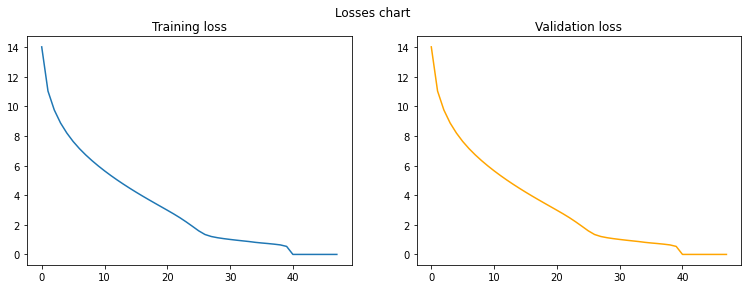

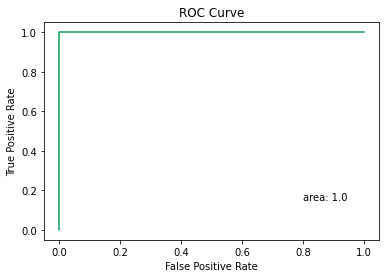

In [245]:
"""
Example of building a logistic regression model. In this example, we use custom training arguments and the fit function
"""
args = TrainingArguments(
            epochs = 2400,
            learning_rate = 0.038,
            batch_size = 0
        )

model = LogisticRegressionModel(mu=mu, var=var, args=args)

data = model.normalize(dataset=dataset, label="CANCELLED")

x_train, y_train, x_test, y_test = model.train_test_split(dataset=data, label="CANCELLED")

#model.fit(x_train, y_train)
model.fit(x_train, y_train, x_test, y_test)
y_prob = model.predict_proba(x_test)
y_hat = model.predict(x_test)

model.scores(y_test, y_hat)
model.print_curves(loss_steps=50)
model.roc_curve(y_prob, y_test, 100)


In [246]:
"""
loading and pre-process additional data
"""
file_paths = ['2015.csv.zip', '2016.csv.zip']
additional_data, nn_features_map = load_and_preprocess_dataset(file_paths=file_paths, undersampling_fact=1)

** cross validation loss: 0.2452, time (s): 32.5827 **

AP = Actual positive
AN = Actual negative
PP = Prediction positive
PN = Prediction negative

    |     PP |         PN
----+--------+------------
 AP | 155745 | 0
 AN |      0 | 1.1281e+07

Precision: 1.0
Recall: 1.0
F_1 score: 1.0


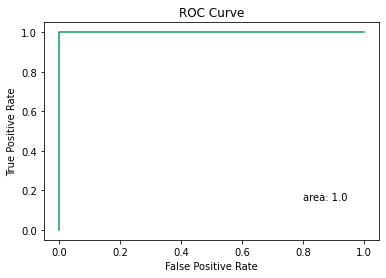

In [265]:
"""
Example of building a logistic regression model. In this example, we use cross valdation to fit the model
"""
args = TrainingArguments(
            epochs = 300,
            learning_rate = 0.031,
            batch_size = 8192
        )

cv_model = LogisticRegressionModel(mu=mu, var=var, args=args)

training_data = cv_model.normalize(dataset=dataset, label="CANCELLED")
test_data = cv_model.normalize(dataset=additional_data, label="CANCELLED")

start = time.time()
cv_loss = cv_model.cross_validation(dataset=training_data, label="CANCELLED", K=10)
cv_time = round(time.time() - start, 4)

X = test_data.drop("CANCELLED", axis=1).to_numpy('float32')
y = test_data["CANCELLED"].to_numpy('int8')

y_hat = cv_model.predict(X)
y_prob = cv_model.predict_proba(X)

print(f"** cross validation loss: {round(cv_loss, 4)}, time (s): {cv_time} **")
cv_model.scores(y, y_hat)
cv_model.roc_curve(y_prob, y, 100)

** best predictor: TrainingArguments(epochs=300, learning_rate=0.031, batch_size=8192), bcv loss: 0.4006, time (s): 612.8382 **

AP = Actual positive
AN = Actual negative
PP = Prediction positive
PN = Prediction negative

    |     PP |         PN
----+--------+------------
 AP | 155745 | 0
 AN |      7 | 1.1281e+07

Precision: 1.0
Recall: 1.0
F_1 score: 1.0


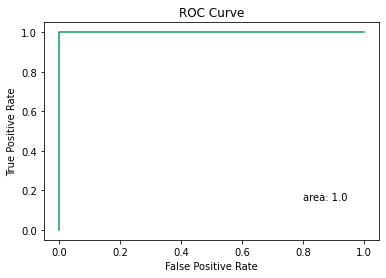

In [268]:
"""
Example of building a logistic regression model using best cross validation method
"""

bcv_model = LogisticRegressionModel(mu=mu, var=var)

epochs_range = [150, 250, 300]
lr_range = [0.01, 0.02, 0.031]
bs_range = [2048, 4096, 8192]

training_data = bcv_model.normalize(dataset=dataset, label="CANCELLED")
test_data = bcv_model.normalize(dataset=additional_data, label="CANCELLED")

start = time.time()
bcv_args, bcv_loss = bcv_model.best_cv(dataset=training_data, label="CANCELLED", K=8, epochs_range=epochs_range, lr_range=lr_range, bs_range=bs_range)
bcv_time = time.time() - start

X = test_data.drop("CANCELLED", axis=1).to_numpy('float32')
y = test_data["CANCELLED"].to_numpy('int8')

y_hat = bcv_model.predict(X)
y_prob = cv_model.predict_proba(X)

print(f"** best predictor: {bcv_args}, bcv loss: {round(bcv_loss, 4)}, time (s): {round(bcv_time, 4)} **")
bcv_model.scores(y, y_hat)
cv_model.roc_curve(y_prob, y, 100)

** best predictor: TrainingArguments(epochs=150, learning_rate=0.02, batch_size=4096), ncv loss: 0.2489, time (s): 4306.3523 **

AP = Actual positive
AN = Actual negative
PP = Prediction positive
PN = Prediction negative

    |     PP |         PN
----+--------+------------
 AP | 155745 | 0
 AN |      0 | 1.1281e+07

Precision: 1.0
Recall: 1.0
F_1 score: 1.0


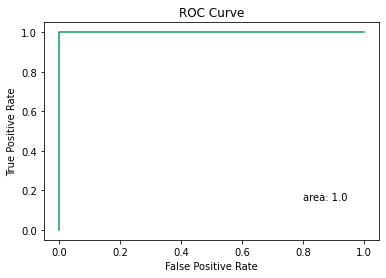

In [275]:
"""
Example of building a logistic regression model. In this example we use nested cross validation to fit the model
"""

ncv_model = LogisticRegressionModel(mu=mu, var=var)

epochs_range = [150, 250, 300]
lr_range = [0.01, 0.02, 0.031]
bs_range = [2048, 4096, 8192]

training_data = ncv_model.normalize(dataset=dataset, label="CANCELLED")
test_data = ncv_model.normalize(dataset=additional_data, label="CANCELLED")

start = time.time()
ncv_args, ncv_loss = ncv_model.nested_cross_validation(dataset=training_data, label="CANCELLED", K=8, epochs_range=epochs_range, lr_range=lr_range, bs_range=bs_range)
ncv_time = time.time() - start

X = test_data.drop("CANCELLED", axis=1).to_numpy('float32')
y = test_data["CANCELLED"].to_numpy('int8')

y_hat = ncv_model.predict(X)
y_prob = ncv_model.predict_proba(X)

print(f"** best predictor: {ncv_args}, ncv loss: {round(ncv_loss, 4)}, time (s): {round(ncv_time, 4)} **")
ncv_model.scores(y, y_hat)
ncv_model.roc_curve(y_prob, y, 100)